## General Imports

In [1]:
from itertools import cycle
from typing import Dict, List
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.base import BaseEstimator
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from deepchecks import CheckResult, Dataset, SingleDatasetBaseCheck
from deepchecks.base import ConditionResult, Suite

np.random.seed(42)

## Load Data, Split Train-Val

In [2]:
iris_df = load_iris(return_X_y=False, as_frame=True)['frame']
label_col = 'target'
df_train, df_test = train_test_split(iris_df, stratify=iris_df[label_col], random_state=0)

### Data sample:

In [3]:
df_test.head(12)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
39,5.1,3.4,1.5,0.2,0
12,4.8,3.0,1.4,0.1,0
48,5.3,3.7,1.5,0.2,0
23,5.1,3.3,1.7,0.5,0
81,5.5,2.4,3.7,1.0,1
55,5.7,2.8,4.5,1.3,1
99,5.7,2.8,4.1,1.3,1
9,4.9,3.1,1.5,0.1,0
85,6.0,3.4,4.5,1.6,1
129,7.2,3.0,5.8,1.6,2


## Define Deepchecks Datasets

In [4]:
ds_train = Dataset(df_train, label=label_col)
ds_test =  Dataset(df_test,  label=label_col)

## Train Model

In [5]:
rf_clf = RandomForestClassifier()
rf_clf.fit(ds_train.features_columns(), ds_train.label_col());

## Define Custom Check

Our custom check class will inherit from SingleDatasetBaseCheck because it is used for single dataset checks.
Other available classes are:

In [6]:
import deepchecks
print([class_name for class_name in dir(deepchecks.base.check) if class_name.endswith('BaseCheck')])

['BaseCheck', 'CompareDatasetsBaseCheck', 'ModelOnlyBaseCheck', 'SingleDatasetBaseCheck', 'TrainTestBaseCheck']


### The check we are creating finds diffrence in target prediction distribution by bins of a selected numeric feature.<br>It also displays an histogram for that data.

In [7]:
# while defining the check the summary will be visible in the display.
class CustomCheck(SingleDatasetBaseCheck):
    '''find diffrence in target prediction distribution by bins of a selected numeric feature'''
    
    # we will set the veriables we want to use in the check in it's init function
    def __init__(self, selected_feature: str, bins_amount: int = 3):
        self.selected_feature = selected_feature
        self.bins_amount = bins_amount
        super().__init__()

    # the run function for subclasses of SingleDatasetBaseCheck recives a dataset and a model
    def run(self, dataset: Dataset, model: BaseEstimator) -> CheckResult:
        binned_col_name = self.selected_feature + ' binned'
        y_pred = model.predict(dataset.features_columns())

        min_val = dataset.data[self.selected_feature].min()
        max_val = dataset.data[self.selected_feature].max()
        increment = (max_val - min_val) / self.bins_amount
        
        bins = []
        labels = []
        for i in range(self.bins_amount):
            labels.append(i + 1)
            bins.append(min_val + i * increment)
        bins.append(min_val + self.bins_amount * increment)
        df = dataset.data.copy()
        df[binned_col_name] = pd.cut(dataset.data[self.selected_feature], bins, labels=labels, include_lowest=True)
        df['y_pred'] = y_pred

        targets = dataset.label_col().unique()
        dist_ratio = {}
        for bin_i in range(self.bins_amount): 
            dist_ratio[bin_i] = {}
            for target in targets:
                dist = df.loc[df[binned_col_name] == (bin_i + 1)]
                tot_in_bin = len(dist)
                tot_of_target = len(dist.loc[dist['y_pred'] == target])
                dist_ratio[bin_i][target] = tot_of_target / tot_in_bin
        dist_ratio['original'] = {}
        len_df = len(df)
        for target in targets:
            tot_of_target = len(df.loc[df['y_pred'] == target])
            dist_ratio['original'][target] = tot_of_target / len_df  
        
        # add custom display function
        def display():
            targets_range = (dataset.label_col().min(), dataset.label_col().max())
            fig, axs = plt.subplots(1, self.bins_amount + 1, tight_layout=True)
            fig.suptitle(f'Disterbution of {self.selected_feature} [{min_val:.2}, {max_val:.2}]', fontsize=16)
            plt.setp(axs, xticks=targets)
            for i in range(self.bins_amount):
                dist = df.loc[df[binned_col_name] == (i + 1)]['y_pred']
                axs[i].hist(dist, range=targets_range)
                axs[i].set_xlabel(f'bin {i+1}')
            axs[self.bins_amount].hist(df['y_pred'], range=targets_range)
            axs[self.bins_amount].set_xlabel('original dataset')

        return CheckResult(dist_ratio, display=display, check=self.__class__)

## Run the custom check

In [8]:
val = CustomCheck('petal width (cm)').run(ds_test, rf_clf)

Custom Check

find diffrence in target prediction distribution by bins of a selected numeric feature

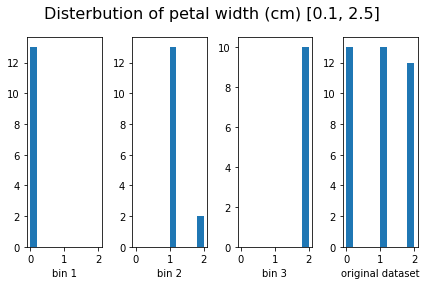

In [9]:
val

## Add a custom condition on the fly

#### A condition for a check defines when we can see the check as a success or a failure. <br> For that we will define a class function that will add the condition function for the check. The condition function will return a ConditionResult object that recives True if the condition applys or False if not (you can also add a potential text that explain why it failed)

In [10]:
def add_condition_distribution_change_not_greater_than(self, max_change = 0.33):
    # define custom condition function
    def condition(result: Dict) -> ConditionResult:
        failed_bins = {}
        original_dist = result.pop('original')
        for bin_i in result.keys():
            failed_targets = {}
            for target in original_dist.keys():
                bin_ratio = result[bin_i][target]
                original_ratio = original_dist[target]
                change = bin_ratio - original_ratio
                change = max(change, -change)
                if change > max_change:
                    failed_targets[target] = f'target {target}: ratio {bin_ratio:.2} vs {original_ratio:.2}'
            if failed_targets:
                failed_bins[bin_i + 1] = f'bin {bin_i + 1}: {list(failed_targets.values())}'
        if failed_bins:
            return ConditionResult(False,
                                   f'{list(failed_bins.values())}')
        else:
            return ConditionResult(True)

    return self.add_condition(f'Change not greater than {max_change}', condition)

#### After defining the condition we need to add it to our class. We can use the following way if we didn't defined the condition inside the check class or if the check is built in.

In [11]:
CustomCheck.add_condition_distribution_change_not_greater_than = add_condition_distribution_change_not_greater_than

## Run a simple custom suite

#### The suite is also the best way to view checks with conditions.

In [12]:
# define the check to run in the suite
check = CustomCheck('sepal width (cm)').add_condition_distribution_change_not_greater_than()

Custom Suite 
 The suite is composed of various checks such as: Custom Check, etc... 
 Each check may contain conditions (which results in 
 ✓ /
 ✖ /
 ! 
 ), as well as other outputs such as plots or tables. 
 Suites, checks and conditions can all be modified (see tutorial [link]). 
 Conditions Summary

Status,Check,Condition,More Info
✖,Custom Check - Test Dataset,Change not greater than 0.33,"[""bin 1: ['target 0: ratio 0.0 vs 0.34']"", ""bin 3: ['target 0: ratio 0.75 vs 0.34']""]"


Additional Outputs

Custom Check - Test Dataset

find diffrence in target prediction distribution by bins of a selected numeric feature

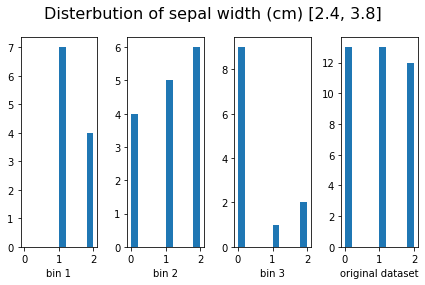

In [13]:
Suite('Custom Suite', check).run(train_dataset=ds_train, test_dataset=ds_test, model=rf_clf, check_datasets_policy='test')